In [1]:
import pandas as pd
import numpy as np


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df

In [3]:
len(train_df.columns)

12

In [4]:
for col in train_df.columns:
    print(col, train_df[col].unique())

User_ID [1000001 1000002 1000003 ... 1004113 1005391 1001529]
Product_ID ['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853']
Gender ['F' 'M']
Age ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']
Occupation [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
City_Category ['A' 'C' 'B']
Stay_In_Current_City_Years ['2' '4+' '3' '1' '0']
Marital_Status [0 1]
Product_Category_1 [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Product_Category_2 [nan  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Product_Category_3 [nan 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]
Purchase [ 8370 15200  1422 ...   135   123   613]


In [7]:
train_df.groupby(['User_ID']).sum()['Purchase']

User_ID
1000001     334093
1000002     810472
1000003     341635
1000004     206468
1000005     821001
            ...   
1006036    4116058
1006037    1119538
1006038      90034
1006039     590319
1006040    1653299
Name: Purchase, Length: 5891, dtype: int64

In [32]:
pd.set_option('display.max_rows',  99)

In [ ]:
print(train_df.groupby(['User_ID']).count()['Product_ID'].sort_values(ascending=False))

In [ ]:
# feature representing the count of each user
def getCountVar(compute_df, count_df, var_name):
    grouped_df = count_df.groupby(var_name)
    count_dict = {}
    for name, group in grouped_df:
        count_dict[name] = group.shape[0]
        print(group)
    count_list = []
    for index, row in compute_df.iterrows():
        name = row[var_name]
        count_list.append(count_dict.get(name, 0))
    return count_list
getCountVar(train_df, train_df, 'User_ID')

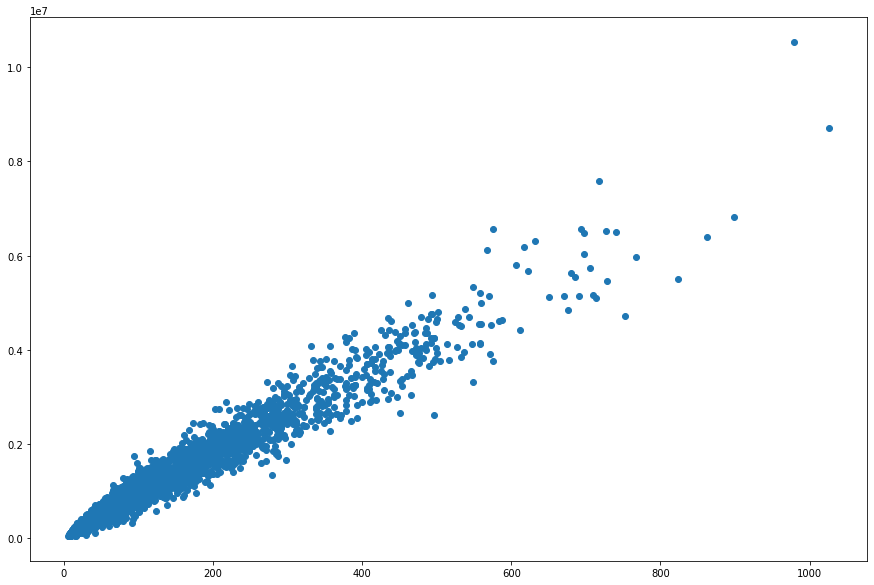

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))
plt.scatter(train_df.groupby(['User_ID']).count()['Product_ID'],train_df.groupby(['User_ID']).sum()['Purchase'])

In [ ]:
set(test_df['Product_ID']) - set(train_df['Product_ID'])

In [ ]:
import matplotlib.pyplot as plt
fig, ax =  plt.subplots(3,3, figsize=(10,6))
i = j = 0
for col in set(train_df.columns) - set(['User_ID','Product_ID','Purchase']):
    ax[i,j].scatter(train_df[col], train_df['Purchase'])
    j+=1
    if(j == 3):
        j = 0
        i+=1

In [ ]:
num_of_training_samples = len(train_df)
df_combined = train_df.append(test_df, sort = False)

In [ ]:
#Categorical Encoding
df_combined['Product_Category_2'] = df_combined['Product_Category_2'].fillna(value = df_combined['Product_Category_2'].value_counts().index[0])
df_combined['Product_Category_3'] = df_combined['Product_Category_3'].fillna(value = df_combined['Product_Category_3'].value_counts().index[0])
df_combined_filled_na = df_combined.copy()
df_combined = pd.get_dummies(df_combined, drop_first = True, columns = ['City_Category', 'Age', 'Gender','Occupation',
                                                              'Stay_In_Current_City_Years', 'Marital_Status',
                                                              'Product_Category_1','Product_Category_2',
                                                               'Product_Category_3'])

In [ ]:
df_combined.columns

In [ ]:
df_combined.shape

In [ ]:
df_combined

In [ ]:
train_df_operate = df_combined.head(num_of_training_samples)
test_df_operate = df_combined.tail(len(df_combined) - num_of_training_samples)
train_df_operate = train_df_operate.reindex(np.random.permutation(train_df_operate.index))
train_df_operate

In [ ]:
train_df_operate

In [ ]:
train_df_operate.columns

In [ ]:
purchase_amount = train_df_operate['Purchase']
train_df_operate.drop(['User_ID', 'Product_ID','Purchase' ], inplace=True, axis = 1)
train_df_operate

In [ ]:
#X_train and y_train
y_train = purchase_amount.values
X_train = train_df_operate.values

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
score=cross_validate(lr, X_train, y_train, cv=10, scoring="neg_root_mean_squared_error")["test_score"].mean()
print(f"{score:.6f}")

lr.fit(X_train, y_train)

In [ ]:
import xgboost
from sklearn.model_selection import cross_validate
xgbr = xgboost.XGBRegressor(n_estimators = 1000)
xgb_score=cross_validate(xgbr, X_train, y_train, cv=4, scoring="neg_root_mean_squared_error")["test_score"].mean()
print(f"{xgb_score:.6f}")

In [ ]:
print(f"{xgb_score:.6f}") #2892  #-2879.968417

In [ ]:
xgbr.fit(X_train, y_train)

In [ ]:
test_df_operate['Purchase'] = xgbr.predict(X_test)

test_df_operate.to_csv('submission_xgb1.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 10)
rfr_score=cross_validate(rfr, X_train, y_train, cv=3, scoring="neg_root_mean_squared_error")["test_score"].mean()
print(f"{rfr_score:.6f}")

In [ ]:
rfr = RandomForestRegressor(n_estimators = 10)
rfr.fit(X_train, y_train)

In [ ]:
rfr

In [ ]:
test_df_operate

In [ ]:
X_test = test_df_operate.drop(['User_ID', 'Product_ID','Purchase' ], axis = 1).values
test_df_operate['Purchase'] = lr.predict(X_test)

test_df_operate.to_csv('submission.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

In [ ]:
test_df_operate['Purchase'] = rfr.predict(X_test)

test_df_operate.to_csv('submission_rfr.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

In [ ]:
y_train_cat = df_combined_filled_na.head(num_of_training_samples)['Purchase']
y_train_cat

In [ ]:
df_combined_filled_na.drop(['User_ID', 'Product_ID','Purchase' ], inplace=True, axis = 1)

In [ ]:
df_combined_filled_na.dtypes

In [ ]:
for col in df_combined_filled_na.columns:
    if(df_combined_filled_na[col].dtype == np.float64):
        df_combined_filled_na[col] = df_combined_filled_na[col].astype(np.int64)
        print(col)
df_combined_filled_na.dtypes

In [ ]:
df_combined_filled_na.columns

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# cbr_score=cross_validate(cbr, df_combined_filled_na.head(num_of_training_samples), y_train_cat, cv=3, scoring="neg_root_mean_squared_error")["test_score"].mean()
# print(f"{cbr_score:.6f}")
X_train_cat, X_valid_cat,y_train_cat , y_valid_cat = train_test_split(df_combined_filled_na.head(num_of_training_samples),
                                                                   y_train_cat, test_size=0.10, random_state=23)

In [ ]:
cbr = CatBoostRegressor(learning_rate = 0.15,
                        eval_metric = 'RMSE',
                        iterations = 150,
                        loss_function = 'RMSE',
                          depth=15)

In [ ]:
print(f"{cbr_score:.6f}")  #3478.619613 for 50  #-4883.360736 for 100 #3118.847380 for 100 with 0.1
#3103.327022 for 150 with 0.1 #3017.578710 for 250, 0.1 #3031.269849 for 250 0.2  
#2855 for 134 0.15 #2857.0936289 for 0.125 

In [ ]:
cbr.fit(X_train_cat, y_train_cat,eval_set=(X_valid_cat,y_valid_cat), plot=True, cat_features = list(range(0,9)))

In [ ]:
dir(cbr)

In [ ]:
df_combined_filled_na.head(num_of_training_samples)

In [ ]:
pred = cbr.predict(df_combined_filled_na.head(num_of_training_samples)[500001:])

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_cat = mean_squared_error(y_train_cat[500001:], pred)
print(rmse_cat)
rmse_cat = np.sqrt(rmse_cat)
rmse_cat #4193.623403601055 => 200  #4192.498990834034  => 500 #2887.796025942559

In [ ]:
dir(cbr)

In [ ]:
cbr.get_param('pool')

In [ ]:
cbr.shrink(143)

In [ ]:
X_test = df_combined_filled_na.tail(len(df_combined) - num_of_training_samples)

In [ ]:
test_df_operate = df_combined.tail(len(df_combined) - num_of_training_samples)
test_df_operate['Purchase'] = cbr.predict(X_test)

test_df_operate.to_csv('submission_cbr_2.csv',columns = ['Purchase','User_ID', 'Product_ID'], index = False)

In [ ]:
X_test

In [ ]:
df_combined_filled_na